# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Импортирование библиотек

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import Pool, cv
from catboost import CatBoostRegressor

## Подготовка данных

### Загружаю и анализирую датафрейм

In [10]:
#загружаю датасет
try:
    data = pd.read_csv('/Users/kostyatrufanov/Downloads/autos.csv')
except:
    data = pd.read_csv('/datasets/autos.csv')

In [12]:
#вывожу первые пять столбцов
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [14]:
#общая информация о таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [16]:
#числовая информация о таблице
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


### Убираю аномальные значения

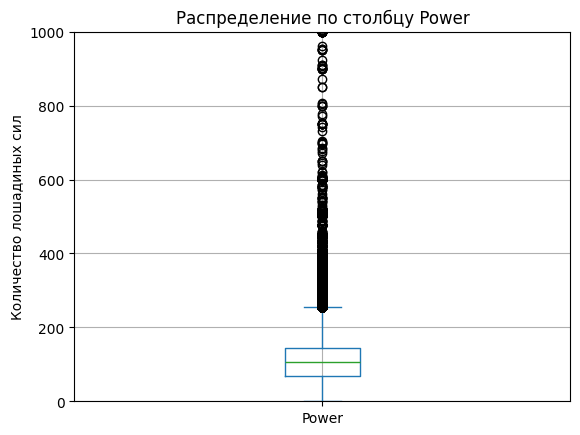

In [19]:
#строю ящик с усами для столбца power
data['Power'].plot.box()
plt.grid(True)
plt.ylim(0, 1000);
plt.ylabel('Количество лошадиных сил');
plt.title('Распределение по столбцу Power');

**Я считаю стоит убрать значения, которые больше 99,8 квантиля и равные 0**

In [22]:
#убираю значения, которые больше 99,8 квантиля и равные нулю
data = data[(data['Power']<data['Power'].quantile(0.998))&(data['Power']>0)]

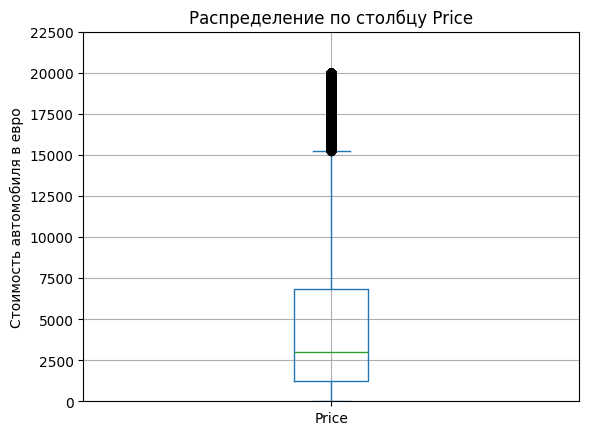

In [24]:
#строю ящик с усами для столбца price
data['Price'].plot.box()
plt.grid(True)
plt.ylim(0, 22500);
plt.ylabel('Стоимость автомобиля в евро');
plt.title('Распределение по столбцу Price');

**В этом случае я считаю, что надо убрать значения, которые меньше, чем 5 квантиль**

In [29]:
#убираю значения, которые меньше 1 квантиля
data = data[data['Price']>data['Price'].quantile(0.05)]

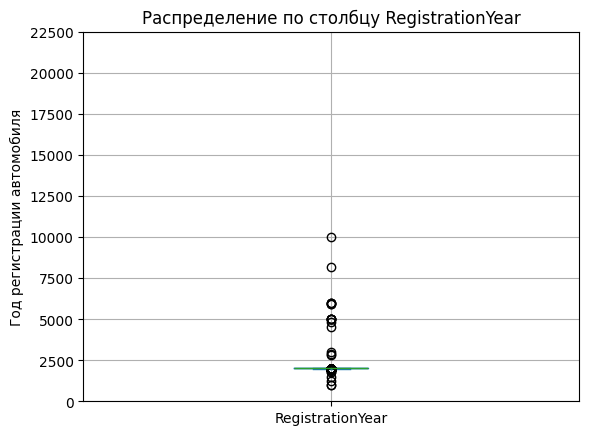

In [31]:
#строю ящик с усами для столбца RegistrationYear
data['RegistrationYear'].plot.box()
plt.grid(True)
plt.ylim(0, 22500);
plt.ylabel('Год регистрации автомобиля');
plt.title('Распределение по столбцу RegistrationYear');

**Так как в описание проекта ничего не написано о том, какого года данные,
так что будем считать, что данные больше 2023 года надо удалить**

In [34]:
#убираю значения больше 2023 года
data = data[data['RegistrationYear']<2023]

### Заполняю пропуски

In [37]:
#смотрю в каких столбцах пропуски и сколько их
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          19497
RegistrationYear         0
Gearbox               5490
Power                    0
Model                11563
Kilometer                0
RegistrationMonth        0
FuelType             17898
Brand                    0
Repaired             43420
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

**Я считаю, что в столбце Model пропущенные значения можно заполнить словом other. В столбце Repaired пропуски можно заполнить словом no, будем считать, что каждый продавец честный и не указал был ремонт или нет, из-за того, что его не было, а не из-за того, что он хочет скрыть информацию от покупателя. А для других столбцов у меня есть идея, как можно заполнить пропуски**

In [40]:
#заполняю пропуски в столбцах Model и Repaired
data['Model'] = data['Model'].fillna('other')
data['Repaired'] = data['Repaired'].fillna('no')

In [42]:
#создаю функцию для заполнения пропусков с помощью предсказания
def isna(data, column):
    #создаю список со всеми значениями столбца, в котором я буду заполнять пропуски
    a = data[column].unique()
    b = [np.nan]
    #убираю пропуски, чтобы не кодировать их
    z = [x for x in a if x not in b]
    #кодирую все значения цифрами, чтобы можно было обучить модель 
    for i in range(len(z)):
        data.loc[data[column]==z[i], column] = i
    #создаю две таблицы, в одной есть пропуски, а в другой нет
    x = data[data[column].isna()==0]
    y = data[data[column].isna()==1]
    #отделяю целевой признак от таблиц
    features_x = x.drop(labels=column, axis=1)
    target_x = x[column]
    #меняю тип данных, чтобы можно было обучить модель
    target_x = target_x.astype('int')
    features_y = y.drop(labels=column, axis=1)
    #заменяю категориальные признаки на цифры
    encoder = OrdinalEncoder()
    encoder.fit(features_x)
    x_ordinal = pd.DataFrame(encoder.transform(features_x), columns=features_x.columns)
    y_ordinal = pd.DataFrame(encoder.transform(features_y), columns=features_y.columns)
    #создаю и обучаю модель для предсказания пропусков
    model = DecisionTreeClassifier()
    model.fit(x_ordinal, target_x)
    predict = model.predict(y_ordinal)
    #создаю таблицу с двумя столбцами, в первом предсказания будут в числовом виде, а во втором предсказания будут в виде слов
    zero = []
    for k in range(len(predict)):
        zero.append(0)
    double_zero = list(zip(zero, zero))
    df = pd.DataFrame(double_zero, columns=['figure', 'words'])
    df['figure'] = predict
    for j in range(len(z)):
        df.loc[df['figure']==j, 'words'] = z[j]
    #считаю accuracy
    score = accuracy_score(target_x, model.predict(x_ordinal))
    return score, df

In [44]:
#предсказываю пропуски для столбца VehicleType
#разделяю таблицу на две части, в одной есть пропуски, а в другой нет
data0 = data[data['VehicleType'].isna()==0]
data1 = data[data['VehicleType'].isna()==1]
#создаю отдельную таблицу для функции
data2 = data[['Model', 'Brand', 'VehicleType']]
#сохраняю значение метрики и предсказания
score, df = isna(data2, 'VehicleType')
#вставляю предсказания
data1['VehicleType'] = np.array(df['words'])
#соединяю две таблицы
data = pd.concat([data0, data1])
#вывожу метрику, новую таблицу и проверяю есть ли пропуски
display(f'Насколько хорошо модель предсказала пропуски: {score}')
display(f'Количество пропусков:{data["VehicleType"].isna().sum()}')
data.head()

/var/folders/j1/s87kb4rs25s6jmdt61g1wsxr0000gn/T/ipykernel_72355/1706552367.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'coupe' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['figure']==j, 'words'] = z[j]
/var/folders/j1/s87kb4rs25s6jmdt61g1wsxr0000gn/T/ipykernel_72355/2394747498.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['VehicleType'] = np.array(df['words'])


'Насколько хорошо модель предсказала пропуски: 0.6643006639722864'

'Количество пропусков:0'

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07


In [46]:
#предсказываю пропуски для столбца Gearbox
#разделяю таблицу на две части, в одной есть пропуски, а в другой нет
data0 = data[data['Gearbox'].isna()==0]
data1 = data[data['Gearbox'].isna()==1]
#создаю отдельную таблицу для функции
data2 = data[['Model', 'Brand', 'Gearbox']]
#сохраняю значение метрики и предсказания
score, df = isna(data2, 'Gearbox')
#вставляю предсказания
data1['Gearbox'] = np.array(df['words'])
#соединяю две таблицы
data = pd.concat([data0, data1])
#вывожу метрику, новую таблицу и проверяю есть ли пропуски
display(f'Насколько хорошо модель предсказала пропуски: {score}')
display(f'Количество пропусков:{data["Gearbox"].isna().sum()}')
data.head()

/var/folders/j1/s87kb4rs25s6jmdt61g1wsxr0000gn/T/ipykernel_72355/1706552367.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'manual' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['figure']==j, 'words'] = z[j]
/var/folders/j1/s87kb4rs25s6jmdt61g1wsxr0000gn/T/ipykernel_72355/3610372632.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Gearbox'] = np.array(df['words'])


'Насколько хорошо модель предсказала пропуски: 0.8434978548880729'

'Количество пропусков:0'

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07


In [48]:
#предсказываю пропуски для столбца FuelType
#разделяю таблицу на две части, в одной есть пропуски, а в другой нет
data0 = data[data['FuelType'].isna()==0]
data1 = data[data['FuelType'].isna()==1]
#создаю отдельную таблицу для функции
data2 = data[['Model', 'Brand', 'FuelType']]
#сохраняю значение метрики и предсказания
score, df = isna(data2, 'FuelType')
#вставляю предсказания
data1['FuelType'] = np.array(df['words'])
#соединяю две таблицы
data = pd.concat([data0, data1])
#вывожу метрику, новую таблицу и проверяю есть ли пропуски
display(f'Насколько хорошо модель предсказала пропуски: {score}')
display(f'Количество пропусков:{data["FuelType"].isna().sum()}')
data.head()

/var/folders/j1/s87kb4rs25s6jmdt61g1wsxr0000gn/T/ipykernel_72355/1706552367.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'gasoline' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['figure']==j, 'words'] = z[j]
/var/folders/j1/s87kb4rs25s6jmdt61g1wsxr0000gn/T/ipykernel_72355/1560378766.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['FuelType'] = np.array(df['words'])


'Насколько хорошо модель предсказала пропуски: 0.7363581241321905'

'Количество пропусков:0'

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07


In [50]:
#еще раз проверяю, что в таблице не осталось ни одного пропуска
data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

### Проверяю на дубликаты

In [53]:
#считаю количество дубликатов
data.duplicated().sum()

5

In [55]:
#убираю дубликаты 
data = data.drop_duplicates(keep='first')

In [57]:
#проверяю
data.duplicated().sum()

0

### Убираю неинформативные признаки

In [60]:
#создаю список ненужных признаков
unnecessary_features = ['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']

In [62]:
#удаляю ненужные признаки 
data = data.drop(labels=unnecessary_features, axis=1)

In [64]:
#проверяю
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...,...
352626,1850,small,2000,manual,89,other,150000,7,petrol,fiat,no
352841,999,sedan,2017,auto,54,other,150000,0,petrol,mercedes_benz,no
353062,799,small,2018,manual,59,twingo,150000,11,petrol,renault,no
353104,1200,small,2000,manual,75,other,150000,0,petrol,volkswagen,no


### Вывод: Сохранил данные, убрал аномалии из столбцов Power и Price. В столбцах Model и Repaired пропуски заполнил заглушками, а в столбцах FuelType, Gearbox и VehicleType пропуски заполнил предсказаниями, да в одном из стобцов метрика оказалось не супер хорошой, но я думаю это намного лучше, чем просто заполнить нейтральными значениями. Затем убрал дубликаты, их оказалось не много. В конце убрал неинформативные признаки

## Подготавливаю данные к обучению

In [68]:
#разделяю данные на features и target
features = data.drop(labels='Price', axis=1)
target = data['Price']

In [70]:
#разделяю данные на две выборки 
features_train, features_temporary, target_train, target_temporary = train_test_split(features, target, test_size=0.45,
                                                                                      random_state=12345)
#разделяю временную выборку на две, на тестовую и валидационную
features_valid, features_test, target_valid, target_test = train_test_split(features_temporary, target_temporary,
                                                                            test_size=0.45, random_state=12345)
#проверяю
display(features_train.shape)
display(target_train.shape)
display(features_valid.shape)
display(target_valid.shape)
display(features_test.shape)
target_test.shape

(163136, 10)

(163136,)

(73411, 10)

(73411,)

(60065, 10)

(60065,)

In [72]:
#создаю список с категориальными данными
ordinal = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
#преобразовываю категориальные признаки с помощью техники OrdinalEncoder, поэтому в дальнейшем соревнование линейной регрессии не будет
encoder = OrdinalEncoder(handle_unknown='error')
encoder.fit(features_train.loc[:, ordinal])
features_train.loc[:, ordinal] = encoder.transform(features_train.loc[:, ordinal])
features_valid.loc[:, ordinal] = encoder.transform(features_valid.loc[:, ordinal])
features_test.loc[:, ordinal] = encoder.transform(features_test.loc[:, ordinal])

In [74]:
#поработаем с числами
scaler = StandardScaler()
scaler.fit(features_train)
features_train = pd.DataFrame(scaler.transform(features_train), columns=features_train.columns)
features_valid = pd.DataFrame(scaler.transform(features_valid), columns=features_valid.columns)
features_test = pd.DataFrame(scaler.transform(features_test), columns=features_test.columns)

### Вывод: Подготовил данные к обучению

## Анализ моделей

**В самом начале протестирую деревянные модели**

In [79]:
#начну с дерева решений
grid_space = {'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10],
             'max_features':[1, 3, 5, 7],
             'min_samples_leaf':[2, 3, 4], 
             'min_samples_split':[2, 3, 4],
             'random_state':[12345]}
#создаю модель
model = DecisionTreeRegressor()
grid = GridSearchCV(model, param_grid=grid_space, cv=3, scoring='neg_mean_squared_error')
model_grid = grid.fit(features_train, target_train)
#сохраняю наилучшии параметры
best_parametrs = model_grid.best_params_
best_parametrs

{'max_depth': 10,
 'max_features': 7,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'random_state': 12345}

In [80]:
%%time
model = DecisionTreeRegressor(**best_parametrs)
model.fit(features_train, target_train)

CPU times: user 114 ms, sys: 1.6 ms, total: 116 ms
Wall time: 115 ms


DecisionTreeRegressor(max_depth=10, max_features=7, min_samples_leaf=2,
                      random_state=12345)

In [81]:
%%time 
predict = model.predict(features_valid)
sqrt(mean_squared_error(target_valid, predict))

CPU times: user 5.06 ms, sys: 829 µs, total: 5.89 ms
Wall time: 5.01 ms


2035.8859865251104

In [85]:
#теперь случайный лес
grid_space = {'max_depth':[1, 2, 3, 4, 5],
             'n_estimators':[10, 20, 30, 40, 50],
             'random_state':[12345]}
#создаю модель
model = RandomForestRegressor()
grid = GridSearchCV(model, param_grid=grid_space, cv=3, scoring='neg_mean_squared_error')
model_grid = grid.fit(features_train, target_train)
#сохраняю наилучшии параметры
best_parametrs = model_grid.best_params_
best_parametrs

{'max_depth': 5, 'n_estimators': 40, 'random_state': 12345}

In [87]:
%%time
model = RandomForestRegressor(**best_parametrs)
model.fit(features_train, target_train)

CPU times: user 2.58 s, sys: 10.5 ms, total: 2.59 s
Wall time: 2.59 s


RandomForestRegressor(max_depth=5, n_estimators=40, random_state=12345)

In [89]:
%%time 
predict = model.predict(features_valid)
sqrt(mean_squared_error(target_valid, predict))

CPU times: user 96 ms, sys: 4.63 ms, total: 101 ms
Wall time: 96.9 ms


2442.3122753583243

In [99]:
#теперь проверю catboost
#ищу наилучшее количество итераций с помощью кроссвалидации
data_pool = Pool(data=features_train, label=target_train)
#создаю словарь параметров и подбираю learning_rate
params = {'eval_metric':'MAPE',
         'loss_function':'RMSE',
         'learning_rate':0.4,
         'random_seed':2007, 
         'verbose':1000}
cv_data = cv(
    params=params,
    pool=data_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    verbose=False,
    early_stopping_rounds=200
)

Training on fold [0/5]

bestTest = 0.3591298729
bestIteration = 997

Training on fold [1/5]

bestTest = 0.3594728078
bestIteration = 999

Training on fold [2/5]

bestTest = 0.3570560716
bestIteration = 989

Training on fold [3/5]

bestTest = 0.3611881022
bestIteration = 984

Training on fold [4/5]

bestTest = 0.3568578282
bestIteration = 995



In [101]:
params = {'iterations': 995,
         'eval_metric':'MAPE',
         'loss_function':'RMSE',
         'learning_rate':0.4,
         'random_seed':2007, 
         'verbose':100}
#создаю модель
model = CatBoostRegressor(**params)

In [103]:
%%time
model.fit(data_pool)

0:	learn: 1.4042646	total: 6.47ms	remaining: 6.44s
100:	learn: 0.3853652	total: 383ms	remaining: 3.39s
200:	learn: 0.3670565	total: 740ms	remaining: 2.92s
300:	learn: 0.3572985	total: 1.1s	remaining: 2.54s
400:	learn: 0.3491799	total: 1.46s	remaining: 2.16s
500:	learn: 0.3437409	total: 1.82s	remaining: 1.8s
600:	learn: 0.3395554	total: 2.23s	remaining: 1.46s
700:	learn: 0.3355989	total: 2.59s	remaining: 1.09s
800:	learn: 0.3319970	total: 2.95s	remaining: 714ms
900:	learn: 0.3289102	total: 3.31s	remaining: 345ms
994:	learn: 0.3265350	total: 3.65s	remaining: 0us
CPU times: user 16.7 s, sys: 5.31 s, total: 22 s
Wall time: 3.71 s


In [105]:
%%time
predict = model.predict(features_valid)
sqrt(mean_squared_error(target_valid, predict))

CPU times: user 180 ms, sys: 7.88 ms, total: 188 ms
Wall time: 30 ms


1574.0188581890939

## Проверяю наилучшую модель на тестовой выборке

In [107]:
%%time
model = CatBoostRegressor(**params)
model.fit(features_train, target_train)

0:	learn: 1.4042646	total: 5.34ms	remaining: 5.31s
100:	learn: 0.3853652	total: 377ms	remaining: 3.34s
200:	learn: 0.3670565	total: 736ms	remaining: 2.91s
300:	learn: 0.3572985	total: 1.09s	remaining: 2.52s
400:	learn: 0.3491799	total: 1.46s	remaining: 2.15s
500:	learn: 0.3437409	total: 1.82s	remaining: 1.79s
600:	learn: 0.3395554	total: 2.19s	remaining: 1.43s
700:	learn: 0.3355989	total: 2.57s	remaining: 1.08s
800:	learn: 0.3319970	total: 2.93s	remaining: 710ms
900:	learn: 0.3289102	total: 3.29s	remaining: 344ms
994:	learn: 0.3265350	total: 3.64s	remaining: 0us
CPU times: user 16.7 s, sys: 5.33 s, total: 22 s
Wall time: 3.71 s


In [109]:
%%time
predict = model.predict(features_test)
sqrt(mean_squared_error(target_test, predict))

CPU times: user 147 ms, sys: 15.5 ms, total: 162 ms
Wall time: 26.6 ms


1608.8543000894083

Общий вывод: В само начале загрузил данные, сделал первичный анализ. Затем убрал выбросы, заполнил пропуски, удалил дубликаты и ненужные признаки. После заеялся подготовкой данных к обучению, все категориальные данные преобразовал с помощью техники OrdinalEncoder, затем привел все числы к одному масштабу с помощью StandardScaler. Далее разделил данные на две выборки. После чего уже приступил к проверкам моделей. По моему мнению лучше всего себя проявила модель catboost. Так что catboost больше всего подойдет для заказчика